## 1. Filtering in frequency domain
##### • 1D
##### DFT(Discrete Fourier Transform)
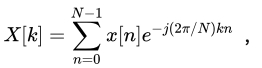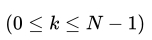
##### IDFT(Inverse discrete Fourier transform)
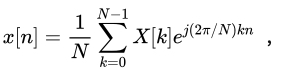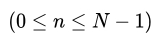
##### FFT(Fast Fourier transform)
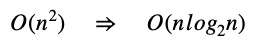

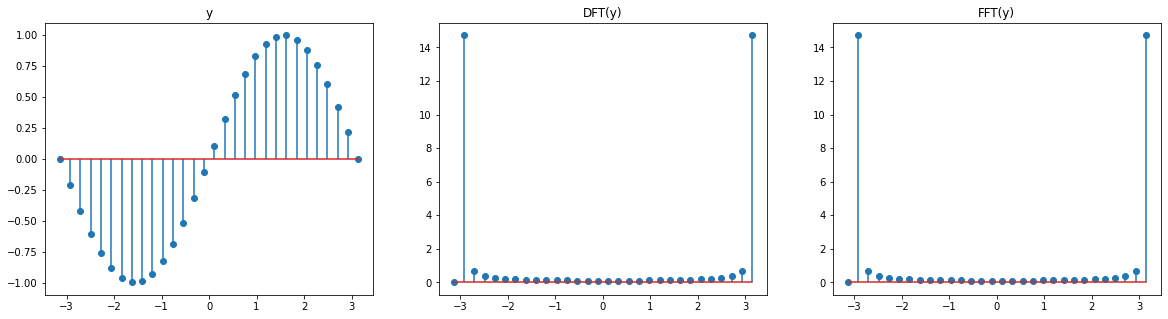

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def DFT(x):
    N = np.size(x)
    X = np.zeros((N,),dtype=np.complex128)
    for k in range(0,N):    
        for n in range(0,N): 
            X[k] += x[n]*np.exp(-np.pi*2j*k*n/N)
    return X

x = np.linspace(-np.pi, np.pi, 30)
y = np.sin(x)
Y = DFT(y) #complex

from numpy.fft import fft, ifft
Y2 = fft(y)

plt.figure(figsize=[20,5])
plt.subplot(131),plt.stem(x,y)
plt.title('y')
plt.subplot(132),plt.stem(x,np.abs(Y))#a+ib->√a^2+b^2
plt.title('DFT(y)')
plt.subplot(133),plt.stem(x,np.abs(Y2))
plt.title('FFT(y)')

plt.show()

##### • 2D
##### DFT
<img src="1.png" width="40%" />

##### IDFT
<img src="2.png" width="40%" />

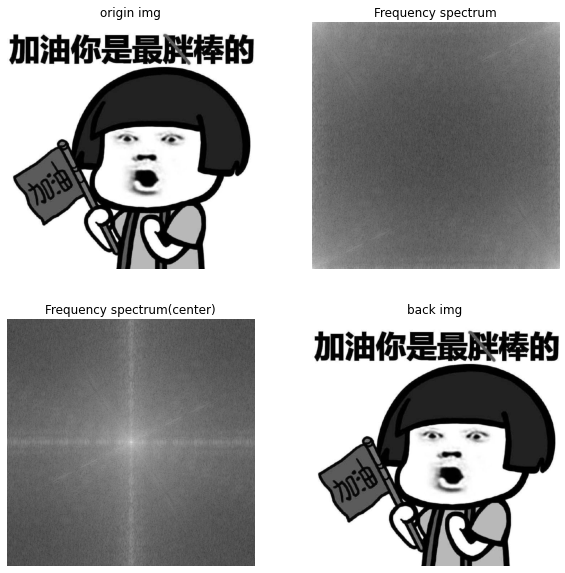

In [15]:
#numpy

import cv2
from numpy.fft import fft2, ifft2, fftshift, ifftshift

img = cv2.imread('./imgs/test1.jpg', 0)#read in gray mode


# fft
f = fft2(img)
f_spectrum = 20*np.log(np.abs(f))
# 频谱中心化
f_shift = fftshift(f)
#对数变换压缩动态范围
f_shift_spectrum = 20*np.log(np.abs(f_shift))

#ifft
f_ishift = ifftshift(f_shift)
img_back = ifft2(f_ishift)
img_back = np.abs(img_back)


plt.figure(figsize=[10,10]),
plt.subplot(221),plt.axis('off')
plt.imshow(img,'gray'),plt.title('origin img')

plt.subplot(222),plt.axis('off')
plt.imshow(f_spectrum,'gray'),plt.title('Frequency spectrum')

plt.subplot(223),plt.axis('off')
plt.imshow(f_shift_spectrum,'gray'),plt.title('Frequency spectrum(center)')

plt.subplot(224),plt.axis('off')
plt.imshow(img_back,'gray'),plt.title('back img')

plt.show()

### • Ideal Filter 
##### Low-pass filter & High-pass filter

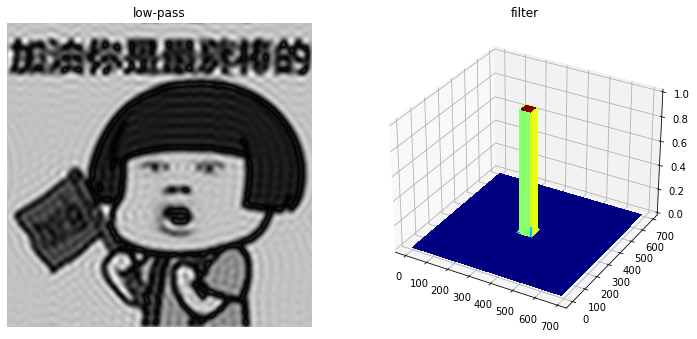

In [14]:
#mask
rows,cols = img.shape
crow,ccol = int(rows/2),int(cols/2)

#Low-pass filter
mask = np.zeros((rows,cols),np.uint8)
mask[crow-30:crow+30,ccol-30:ccol+30] = 1 
f_shift = f_shift * mask

#High-pass filter
# f_shift[crow-50:crow+50, ccol-50:ccol+50] = 0

f_ishift_low = np.fft.ifftshift(f_shift)
img_back_low = np.fft.ifft2(f_ishift_low)
img_back_low = np.abs(img_back_low)

fig = plt.figure(figsize=[12,12])
plt.subplot(121),plt.axis('off')
plt.imshow(img_back_low,'gray'),plt.title('low-pass')

ax = fig.add_subplot(122, projection='3d')
X = np.arange(mask.shape[0])
Y = np.arange(mask.shape[1])
X, Y = np.meshgrid(Y, X)
ax.plot_surface(X, Y, mask, cmap="jet", linewidth=0, antialiased=False)
plt.title('filter')

plt.show()

### • Gaussian Filter
##### Low-pass filter & High-pass filter

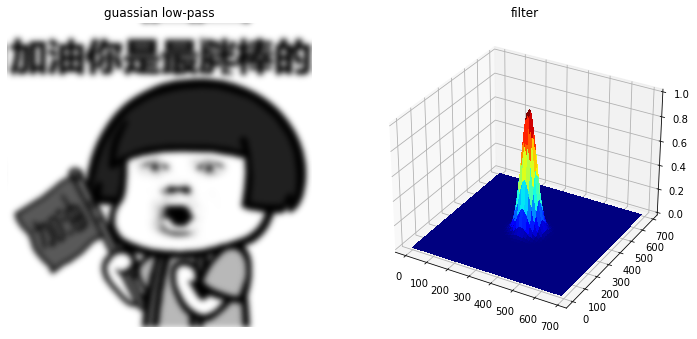

In [17]:
def gaussian(im, gamma):
    h, w = im.shape[0], im.shape[1]
    f = np.zeros_like(im).astype(np.float32)
    for i in range(h):
        for j in range(w):
            f[i,j] = 1/(2*np.pi*gamma**2)*np.exp(((i-h/2)**2+(j-w/2)**2)/(-2*gamma**2))
    f = f/f.max()#normalize
    return f
            
gaussian_filter = gaussian(img, 30)
f_shift = f_shift * gaussian_filter
img_back_low = ifft2(ifftshift(f_shift))
img_back_low = np.abs(img_back_low)

fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(121)
ax.axis('off')
ax.imshow(img_back_low,'gray')
plt.title('guassian low-pass')

ax = fig.add_subplot(122, projection='3d')
X = np.arange(gaussian_filter.shape[0])
Y = np.arange(gaussian_filter.shape[1])
X, Y = np.meshgrid(Y, X)
ax.plot_surface(X, Y, gaussian_filter, cmap="jet", linewidth=1, antialiased=False)
plt.title('filter')

plt.show()

### • Image Denoising

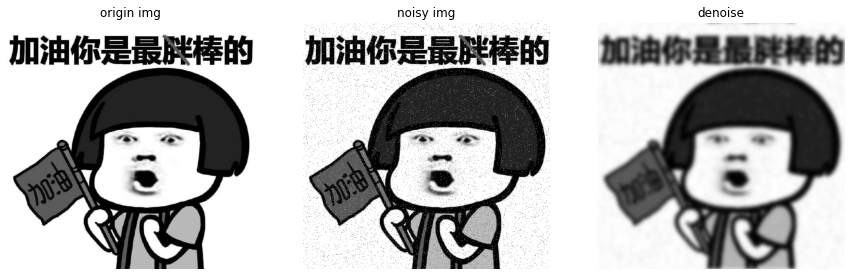

In [18]:
import random
def sp_noise(image,prob):
    '''
    Add salt and pepper noise
    prob: noise ratio 
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

im_noise = sp_noise(img,0.02)

F_im = fftshift(fft2(im_noise))
F_im = F_im * gaussian(im_noise, 20)
IF_im = ifft2(ifftshift(F_im))
IF_im = np.abs(IF_im)
                
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(131)
ax.axis('off')
ax.imshow(img,'gray')
plt.title('origin img')

ax = fig.add_subplot(132)
ax.axis('off')
ax.imshow(im_noise,'gray')
plt.title('noisy img')

ax = fig.add_subplot(133)
ax.axis('off')
ax.imshow(IF_im,'gray')
plt.title('denoise')

plt.show()

## 2.Image Blending
#### Guassian Pyramids & Laplacian Pyramids

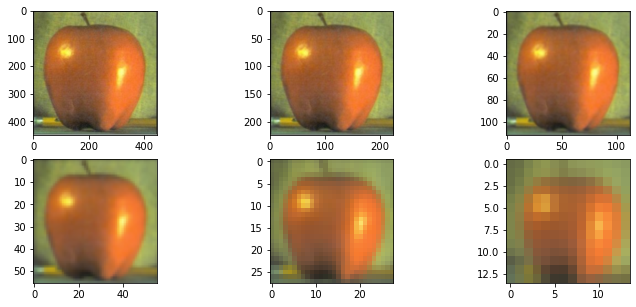

In [131]:
img1 = cv2.imread('./imgs/apple.png')
#print(img.shape)
A = cv2.resize(img1, (448, 448), interpolation=cv2.INTER_CUBIC)  # 做5层金字塔，图像尺寸的大小必须是64的整数倍
img2 = cv2.imread('./imgs/orange.png')
B = cv2.resize(img2, (448, 448), interpolation=cv2.INTER_CUBIC)
#print(A.shape)
#print(B.shape)

# generate Gaussian pyramid for A
G = A.copy()
gpA = [G]
plt.figure(figsize=[12,5])
plt.subplot(231), plt.imshow(cv2.cvtColor(gpA[0], cv2.COLOR_BGR2RGB))
for i in range(5):
    G = cv2.pyrDown(G)
    gpA.append(G)
    plt.subplot(2, 3, i+2), plt.imshow(cv2.cvtColor(gpA[i+1], cv2.COLOR_BGR2RGB))

plt.show()

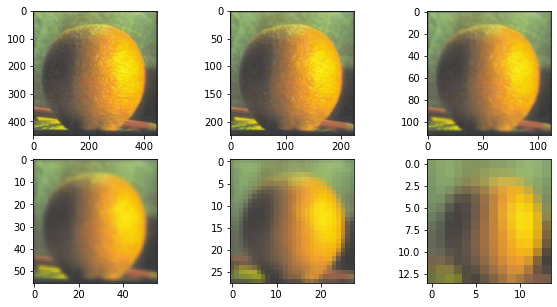

In [121]:
## generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
plt.figure(figsize=[10,5])
plt.subplot(231), plt.imshow(cv2.cvtColor(gpB[0], cv2.COLOR_BGR2RGB))
for i in range(5):
    G = cv2.pyrDown(G)
    gpB.append(G)
    plt.subplot(2, 3, i+2), plt.imshow(cv2.cvtColor(gpB[i+1], cv2.COLOR_BGR2RGB))

plt.show()

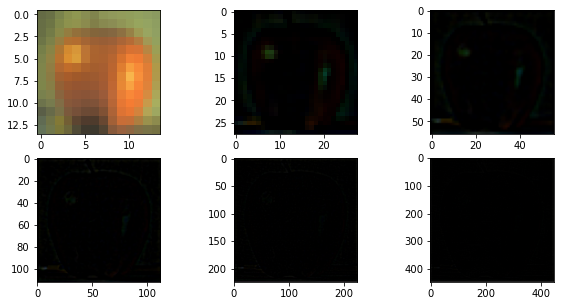

In [122]:
#generate Laplacian Pyramid for A
lpA = [gpA[5]]
plt.figure(figsize=[10,5])
plt.subplot(231), plt.imshow(cv2.cvtColor(lpA[0], cv2.COLOR_BGR2RGB))
for i in range(5, 0, -1):
    GE = cv2.pyrUp(gpA[i])
    L = cv2.subtract(gpA[i-1], GE)
    lpA.append(L)
    plt.subplot(2, 3, 6-i+1), plt.imshow(cv2.cvtColor(L, cv2.COLOR_BGR2RGB))
    
plt.show()

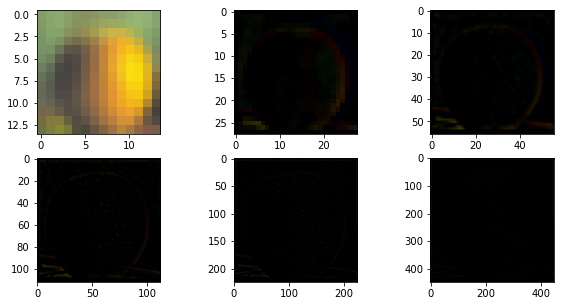

In [123]:
#generate Laplacian Pyramid for B
lpB = [gpB[5]]
plt.figure(figsize=[10,5])
plt.subplot(231), plt.imshow(cv2.cvtColor(lpB[0], cv2.COLOR_BGR2RGB))
for i in range(5, 0, -1):
    GE = cv2.pyrUp(gpB[i])
    L = cv2.subtract(gpB[i-1], GE)
    lpB.append(L)
    plt.subplot(2, 3, 6-i+1), plt.imshow(cv2.cvtColor(L, cv2.COLOR_BGR2RGB))
    
plt.show()

(14, 14, 3)
(28, 28, 3)
(56, 56, 3)
(112, 112, 3)
(224, 224, 3)
(448, 448, 3)


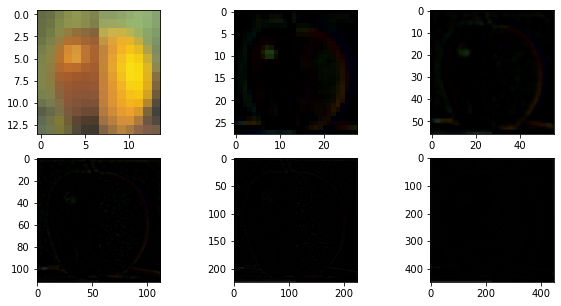

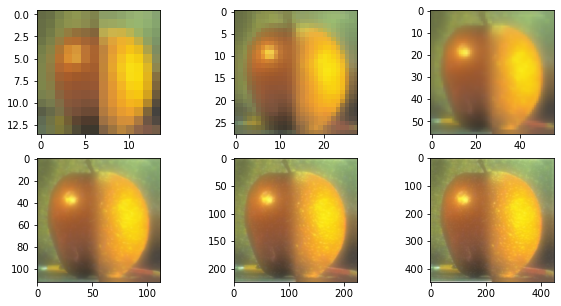

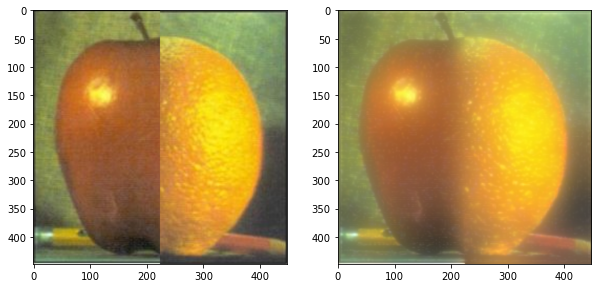

In [127]:
# Now add left and right halves of images in each level
LS = []
i = 1
plt.figure(figsize=[10,5])
for la, lb in zip(lpA, lpB):
    print(la.shape)
    rows, cols, dpt = la.shape
    ls = np.hstack((la[:, 0: int(cols/2)], lb[:, int(cols/2) :]))#将各自的一半拼接
    LS.append(ls)
    plt.subplot(2, 3, i), plt.imshow(cv2.cvtColor(ls, cv2.COLOR_BGR2RGB))
    i += 1 
plt.show()

# now reconstruct
ls_ = LS[0]  # 取出最模糊的那张图片
plt.figure(figsize=[10,5])
plt.subplot(2, 3, 1), plt.imshow(cv2.cvtColor(ls_, cv2.COLOR_BGR2RGB))
for i in range(1, 6):
    ls_ = cv2.pyrUp(ls_)  # 加零，高斯模糊
    ls_ = cv2.add(ls_, LS[i])  # 加差值，提高分辨率
    plt.subplot(2, 3, i+1), plt.imshow(cv2.cvtColor(ls_, cv2.COLOR_BGR2RGB))
plt.show()

# 对比效果
real = np.hstack((A[:, :int(cols/2)], B[:, int(cols/2):]))
plt.figure(figsize=[10,5])
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(real, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(ls_, cv2.COLOR_BGR2RGB))
plt.show()

## 3.Geometric Transformations
rotate matrix：
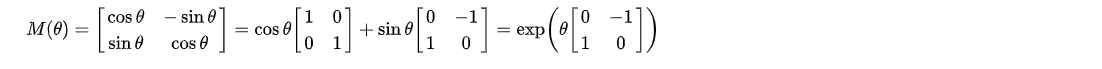

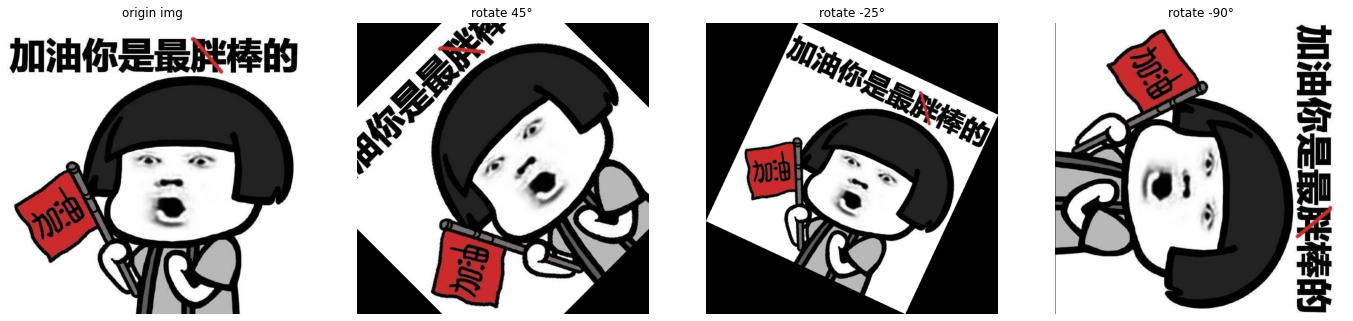

In [128]:
def rotate(img, angle, expand=False):
    h, w, c = img.shape
    ch, cw  = h/2, w/2
    angle = -angle % 360.0 / 180.0 * np.pi #角度转弧度
    matrix = np.matrix([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    
    if expand:
        shape = np.zeros((4,2), dtype=np.int32)
        for index, i, j in [(0,0,0), (1,h,0), (2,0,w), (3,h,w)]:
            coor = np.matrix([[i-ch],[j-cw]])
            rotcoor = np.dot(matrix, coor)#矩阵乘法
            shape[index,0] = np.round(rotcoor[0] + ch).astype(np.int32)
            shape[index,1] = np.round(rotcoor[1] + cw).astype(np.int32)
        rh, rw = shape.max(0) - shape.min(0)
        crh, crw  = rh/2, rw/2
    else:
        rh, rw = h, w
        crh, crw  = rh/2, rw/2

    rimg = np.zeros((rh, rw, c), dtype=np.uint8)

    for ri in range(rh):
        for rj in range(rw):
            coor = np.matrix([[ri-crh],[rj-crw]])
            rotcoor = np.dot(matrix, coor)

            i = np.round(rotcoor[0] + ch).astype(np.int32)
            j = np.round(rotcoor[1] + cw).astype(np.int32)

            if i >= 0 and j >= 0 and i < img.shape[0] and j < img.shape[1]:
                rimg[ri,rj] = img[i,j]

    return rimg
            
img = cv2.imread('./imgs/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

img_r45 = rotate(img, 45)
img_r25 = rotate(img, -25, True)
img_r90 = rotate(img, -90, True)

fig = plt.figure(figsize=[24,6])
ax = fig.add_subplot(141)
ax.axis('off')
ax.imshow(img)
plt.title('origin img')

ax = fig.add_subplot(142)
ax.axis('off')
ax.imshow(visualize(img_r45))
plt.title('rotate 45°')

ax = fig.add_subplot(143)
ax.axis('off')
ax.imshow(visualize(img_r25))
plt.title('rotate -25°')

ax = fig.add_subplot(144)
ax.axis('off')
ax.imshow(visualize(img_r90))
plt.title('rotate -90°')
plt.show()

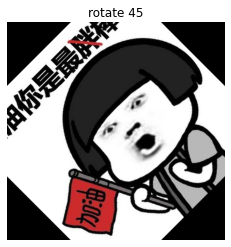

In [21]:
img = cv2.imread('./imgs/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
h,w = img.shape[0],img.shape[1]
center = (w//2,h//2)

M = cv2.getRotationMatrix2D(center, 45, 1.0) #1.0=scale
rotated = cv2.warpAffine(img, M, (w, h)) 
plt.imshow(rotated), plt.title('rotate 45'),plt.axis('off')
plt.show()